# MSc. AI
## Capstone Project
### Darragh Minogue

### 1. Background


This project adopts the facility location problem to the school network in Ethiopia to expand access to secondary education. Of the 40,776 schools in the country, 37,039 offer primary education, but only 3,737 offer secondary. On average, primary schools are located more than 7km away from the nearest secondary school, meaning children face long journeys or they don't access secondary at all.

The expansion of secondary education is a major priority for the Ministry of Education, Ethiopia. Ambitious five year targets are set in the Education Sector Development Plans (ESDP). In 2013/2014, the Gross Enrollment Rate (GER) for lower secondary was 38.9% (3,466,972/8,914,837 children) and a target of 74% (6,596,979/8,914,837 children) was set. However, by 2019/2020, the actual GER was 51.05% (4,551,024/8,914,837 children), a more modest increase of 12.15% rather than 35.1%.  In the latest five year ESDP (2020/2021-2024/2025), an increase of 24% was set, but under the key-performance indicator of 'Number of newly established secondary schools', it says TBD- for 'To Be Determined'. Therein lies part of the problem: planning. Often, a portion of the budget is allocated for secondary, then each region decides how and where to spend it. Planners then, at the macro level, identify primary schools with the highest demand (i.e. largest enrollment) and seek to construct schools to serve that particular school population. While this can often yeild good results, the goal of this project is to improve on this approach in a way that allows for the potential construction of secondary schools across a catchment of multiple primary schools, if enrollment is sufficient and distance is minimal. Meta-heuristic optimisation techniques are used to achieve this.

The project makes use of readily available data from the Ministry of Education, Ethiopia, mainly 1) enrollment data from the Education Managament Information System (EMIS) and 2) geolocation data, recently obtained from the World Bank in 2020. Since national population and census data is inaccurate and outdated in Ethiopia, this was not considered a reliable source for this project. Instead, it is assumed that primary schools are located within the community and new secondary schools should therefore be constructed close to existing primary schools.

### 2. The Problem

In the problem, there is a list of existing primary schools and secondary schools in Ethiopia, their enrollment and location data (region, zone, district, longitude and latitude). The aim is to expand the secondary school network by constructing new secondary schools that best serve the demand from the existing primary school network. No limit is placed on capacity as this is determined by budget which is not known in advance and subject to change (**TO BE CONFIRMED**). Key to solving the problem is understanding that when a school is located within a village, there is no impact of distance on enrolment nor dropout. However, beyond the aspirational norm of 1-2km, distance affects initial access to school but also creates barriers to retention, completion and transition to higher level. As such, the aim is to minimise distance, but construct schools in locations with the highest demand.

### 3. Approach

<b> Glossary of terms</b>
* PS: Primary Schools
* SS: Secondary Schools
* EE: Expected Enrollment
* EEI: Expected Enrollment Increase
* Feeder: a primary school that is part of the secondary school catchment area.
* x: proposed new secondary schools (the genotype).
* d: distance in km between primary schools and 
* proposed_schools: the total number of schools proposed for construction.

This solution proposes new SS locations that can provide the highest estimated enrollment from feeder PS whilst also ensuring they are constructed within at minimal distance. Given the multitude of different languages and the decentralised Government of Ethiopia, models are developed at a regional level.

Two different algorithms are used in this project to find an optimal solution: Random Search, and CMA-ES (**description to follow**). In each of the algorithms, the objective function f() aims to <b> maximise overall expected enrollment </b> given a set of feasible locations: x. Feasibility of the locations or the genotype, x, is controlled using a box boundary of longitudes and latitudes for a given region. Initial starting points are also provided within the box boundary using a generate_random_sp() helper function. 

The fitness is determined using an expected_enrollment function. This takes in the parameters: 1) the location of existing PS, 2) the enrollment of existing PS, 3) x, and 4) the current distance between existing PS and existing SS. The function then calculates the haversine distance in kilometers (km) between each new SS in x and all PS within a given region. This vector, <b> d </b>, is of size: (proposed_schools, len(ps)). Using this data, the algorithm then addresses three key challenges:

1) **The need to identify the PS with the minimal distance to the new SS**. In this case, if a PS is close to two or more new SS, only the closest is selected. But if the PS is closer to an existing SS, then it's ignored as it's already a feeder school to the existing SS.

2) **The need to estimate the expected enrollment of the new SS, based on the distance to its feeder PS**. If a school is beyond a certain threshold distance in km, then the PS should not be considered a feeder school for a SS. To handle this, situation, a helper function is used to estimate the expected enrollment from a feeder PS to the nearby SS. It takes in as parameters a) distance to nearest SS and b) PS enrollment. It then makes some assumptions about distance to return the expected enrollment per school. Theunynck (2014) recommends the adoptation of a norm of 2 or 3km for junior secondary schools and the function therefore assumes that if a school is constructed within 2km of a PS, there is no negative effect on expected enrollment of it's nearby SS. Above 2km, a linear dropoff is assumed between 2-5km. If a PS is located more than 5km away from the new location proposed, it is expected that zero students will attend from that feeder school.

3) **The need to divert expected enrollment from a PS if it is currently a feeder school to an existing SS but the new SS proposed is closer**. This is dealt with by subtracting the expected enrollment from the PS to the existing SS using the shape function, and then allocating it to the new SS which is closer. 

A fitness evaluation budget of 10,000 is set to ensure there are sufficient iterations to achieve convergance. Each algorithm is run 30 times with different random starting points. The results are stored in a csv file, with the top 4 results plotted below. 

### Assumptions and Limitations

1. It is assumed that 1km is equivalent to a 15 minute walk for children (Theunynck, S. 2014: p6).
2. Distance is calculated using the haversine function and as a result distance is calculated as a straight line. The travel distances could therefore be further. Ethiopia is not well mapped and since most children are walking to school using other means like Google Maps API don't yeild useful results on a large scale and don't factor in more informal walking routes. Final results require close inspection for elevation and other issues that might impact walking distance or construction e.g. buildings, rivers. The final results should therefore be observed as an approximation and using a tool like ArcGIS or QGIS, the the results are observed for these types of obstacles. 
3. It is assumed that children beyond 5km are not likely to attend, but in some cases, this is not true. Some children walk extremely long distances to attend secondary school, while others stay with relatives or family friends to attend a school that is beyond 5km. Despite this being a reality, this shouldn't guide the construction as the goal is to minimise distance and create more equitable access to secondary. 

In [1]:
# Key Imports
import pandas as pd
import numpy as np
from haversine import haversine, haversine_vector, Unit
import geopandas as gpd
import matplotlib.pyplot as plt
import cma
import time

# Supress the scientific notation on numpy for easierx reading.
np.set_printoptions(suppress=True)

In [2]:
# Specify which test to perform: 1) basic test with 2 schools, 2) basic test with 1 district, 3) regional test.
declare_test = 3

In [3]:
# Declare key variables according to the test being performed.
region = 'Amhara' # Test Amhara region
woreda = 'ET030908' # for testing of one woreda/district in Amhara.

if declare_test == 1: # for micro test
    # read in the prepared dataset. Evaluate point data to make it readible by geopandas
    df = pd.read_csv('data/test_dataset2.csv', converters={'point': pd.eval})
    proposed_schools= 2
    gdf_woreda = gpd.read_file('eth_shape_files/json/eth_admin3v2.json')
    gdf_woreda_shp = gdf_woreda.loc[gdf_woreda['ADM3_PCODE']==woreda]['geometry'].reset_index(drop=True)
    df = df.loc[df['ADM3_PCODE'] == woreda]
    bounds = gdf_woreda_shp.bounds
elif declare_test == 2: # district or woreda test.
    df = pd.read_csv('data/test_dataset.csv', converters={'point': pd.eval})
    proposed_schools= 5
    gdf_woreda = gpd.read_file('eth_shape_files/json/eth_admin3v2.json')
    gdf_woreda_shp = gdf_woreda.loc[gdf_woreda['ADM3_PCODE']==woreda]['geometry'].reset_index(drop=True)
    df = df.loc[df['ADM3_PCODE'] == woreda]
    bounds = gdf_woreda_shp.bounds
else: # for regional test
    proposed_schools= 5
    df = pd.read_csv('data/clean_dataset.csv', converters={'point': pd.eval})
    # limit geojson to only selected region
    # limit clean dataset to only selected region
    gdf_region = gpd.read_file('eth_shape_files/json//eth_admin1v2.json') # read in geojson
    gdf_region_shp = gdf_region.loc[gdf_region['ADM1_EN']==region]['geometry'].reset_index(drop=True)
    df = df.loc[df['region'] == region]
    bounds = gdf_region_shp.bounds 

In [4]:
df.head(5)

,region,zone,woreda,school_name,school_code,geometry,lat,lon,gr_offer,urban_rural,...,ADM3_PCODE,ADM0_EN,ADM1_EN,ADM2_EN,ADM3_EN,point,nearest_up_prim,nearest_sch_code,nearest_lwr_sec,nearest_up_sec
0,Amhara,Misrak Gojjam,Hulet_Ej_Ene,Tekort,S0306020712,POINT (37.9873 11.0999),11.099900,37.98730,G.1-4,1,...,ET030602,Ethiopia,Amhara,East Gojam,Hulet Ej Enese,"[11.0999, 37.9873]",0.015579,S0306021802,NaN,NaN
1,Amhara,Misrak Gojjam,Hulet_Ej_Ene,Boda Kidanemihiret,S0306021792,POINT (37.69205 11.05947),11.059470,37.69205,G.1-4,1,...,ET030602,Ethiopia,Amhara,East Gojam,Hulet Ej Enese,"[11.05947, 37.69205]",2.090068,S0306020482,NaN,NaN
2,Amhara,Misrak Gojjam,Hulet_Ej_Ene,Meklit,S0306020332,POINT (37.79732 11.077843),11.077843,37.79732,G.1-8,1,...,ET030602,Ethiopia,Amhara,East Gojam,Hulet Ej Enese,"[11.077843, 37.79732]",NaN,S0306180503,8.653923,NaN
3,Amhara,Misrak Gojjam,Sedie,Grarema,S0306020292,POINT (37.9104 10.7492),10.749200,37.91040,G.1-8,1,...,ET030602,Ethiopia,Amhara,East Gojam,Hulet Ej Enese,"[10.7492, 37.9104]",NaN,S0306012833,13.340141,NaN
4,Amhara,Misrak Gojjam,Sedie,Jema,S0306025422,POINT (37.8078 10.88),10.880000,37.80780,G.1-8,1,...,ET030602,Ethiopia,Amhara,East Gojam,Hulet Ej Enese,"[10.88, 37.8078]",NaN,S0306025393,1.156893,NaN


In [5]:
df.columns

Index(['region', 'zone', 'woreda', 'school_name', 'school_code', 'geometry',
       'lat', 'lon', 'gr_offer', 'urban_rural', 'grade7', 'grade8', 'grade7_8',
       'grade1_4', 'grade1_4_f', 'grade1_4_m', 'grade5_8', 'grade5_8_f',
       'grade5_8_m', 'grade9_10', 'grade9_10_f', 'grade9_10_m', 'grade11_12',
       'grade11_12_f', 'grade11_12_m', 'water_y_n', 'has_separate_toilet',
       'has_toilet', 'ADM0_PCODE', 'ADM1_PCODE', 'ADM2_PCODE', 'ADM3_PCODE',
       'ADM0_EN', 'ADM1_EN', 'ADM2_EN', 'ADM3_EN', 'point', 'nearest_up_prim',
       'nearest_sch_code', 'nearest_lwr_sec', 'nearest_up_sec'],
      dtype='object')

In [6]:
# Establish boundaries based on the bounds of region or woreda.
# Latitude is the Y axis, longitude is the X axis.

lat_bounds = bounds[['miny','maxy']].to_numpy(dtype=float)[0]
lon_bounds = bounds[['minx','maxx']].to_numpy(dtype=float)[0]
bounds = np.array([[lat_bounds[0], lon_bounds[0]], [lat_bounds[1], lon_bounds[1]]])
# array - [[lower lat bounds, lower lon bounds],[upper lat bounds, upper lon bounds]]
# CMA expects a list of size 2 for bounds
x1y1 = np.repeat([bounds[0,:]],proposed_schools, axis=0).flatten()
x2y2 = np.repeat([bounds[1,:]],proposed_schools, axis=0).flatten()
boundsxy = [x1y1,x2y2]
boundsxy

[array([ 8.71481253, 35.26108445,  8.71481253, 35.26108445,  8.71481253,
        35.26108445,  8.71481253, 35.26108445,  8.71481253, 35.26108445]),
 array([13.76296565, 40.21243796, 13.76296565, 40.21243796, 13.76296565,
        40.21243796, 13.76296565, 40.21243796, 13.76296565, 40.21243796])]

In [7]:
# Create subset arrays required as input for enrollment function.
# 1. Primary school enrollment data. Only the last two grades as predictors for the two grades of lower secondary.
# 2. Primary school location data: lat lon point data. 
# 3. Secondary schoool location data: lat lon point data. 
# 4. Secondary school enrollment data. Only grades 9 and 10 enrollment. 

df_prim = df.loc[df['grade7_8'] > 0]
df_prim_enroll = df_prim['grade7_8'].reset_index(drop=True).to_numpy(dtype=float)
df_prim_loc = df_prim['point'].reset_index(drop=True).to_numpy()
df_prim_loc = np.array([np.array(i) for i in df_prim_loc], dtype=float)

df_sec = df.loc[ (df['gr_offer'] == 'G. 9-10') | (df['gr_offer'] == 'G. 9-12')]
df_sec_loc = df_sec['point'].reset_index(drop=True).to_numpy()
df_sec_enroll = df_sec['grade9_10'].reset_index(drop=True).to_numpy(dtype=float)
df_sec_loc = np.array([np.array(i) for i in df_sec_loc], dtype=float)

current_ps_distance = df_prim['nearest_lwr_sec'].to_numpy() # existing distance to secondary school

## Helper Functions

In [8]:
# Function to shape expected enrollment. 
def shape(distance, enrollment):
    # If less than 2km, all children expected to attend secondary i.e. distance not a factor
    min_walk = 2 
    max_walk = 5 # distance greater than 5km (1hr 15 mins) assumes school too far, and zero enrollment expected.
    # if between 2-5km, return a linear dropoff.
    return np.where(distance<min_walk, enrollment,
             np.where(distance>max_walk, 0,
                     enrollment*(1-(distance-min_walk)/(max_walk-min_walk)))
            )

# Example below
shape(8, 1000)

array(0.)

In [9]:
# Function to generate random starting points for each proposed school within box boundary.
def generate_random_sp():
    sp1 = np.random.uniform(low=lat_bounds[0], high=lat_bounds[1], size=40000)
    sp2 = np.random.uniform(low=lon_bounds[0], high=lon_bounds[1], size=40000)
    sp = np.vstack((sp1, sp2)).T
    return sp

In [10]:
# Create large vector of 40,000 to sample in RS and CMA. 
sp = generate_random_sp()

In [11]:
# Include only starting points that are within the regional polygon.
def check_region(vec):
    # lat = y, x=lon
    vec = gpd.points_from_xy(vec[:, 1], vec[:, 0])
    return vec.within(gdf_region_shp[0])

def check_woreda(vec):
    # lat = y, x=lon
    vec = gpd.points_from_xy(vec[:, 1], vec[:, 0])
    return vec.within(gdf_woreda_shp[0])

In [12]:
# Create a list of approx 20,000 within the regional boundaries. This will be sampled. 
sp = sp[check_region(sp)]
# sp = sp[check_woreda(sp)]

In [13]:
len(sp)

20825

In [14]:
def generate_sp_proposed(sp_list):
    return sp_list[np.random.choice(sp_list.shape[0], proposed_schools,replace=False)]

In [15]:
# Helper for fitness function to take in a vector of primary schools and the distance, and return jagged array.
def get_close_schools(ps, current_ds):    
    # Gets (index and distance) of schools located less than 5km and less than current distance.
    return [[i, ps[i]] for i in range(len(ps)) if ((ps[i] < 5) & (ps[i] < current_ds[i]))]

## Fitness Function

In [97]:
# Constant
ee_old_constant = np.sum(df_sec_enroll) # existing enrollment for secondary

def expected_enrollment(prim_loc, x, prim_enroll, current_dist):
    ee_old = ee_old_constant.copy() # Overall SS Enrollment
    d = np.min(haversine_vector(prim_loc,x, Unit.KILOMETERS, comb=True), axis=0) # min distance of PS to x. 
    d_index = np.argmin(haversine_vector(prim_loc,x, Unit.KILOMETERS, comb=True), axis=0) # index of min distance of PS to x
    d2 = np.where((d <5) & (d < current_dist)) # limit to only schools < 5km and schools < current distance
    # Put into dataframe. index 0 = SS, index 1 = PS, index 2 = distance, index 3 = shaped enrollment 
    d3 = pd.DataFrame(np.vstack((d_index[d2], d2[0], d[d2], shape(d[d2], prim_enroll[d2[0]]))).T) 
    d32 = d3.loc[d3.groupby([1])[2].idxmin()] # find only nearby SS if PS is close to more than 1 SS.
    d32 = d32.groupby(0)[3].sum() # sum the overall shaped enrollment by school. 
    eei = np.sum(d32) # sum overall expected enrollment
     # find SS enrollment of SS if close to old SS. 
    distance_current = np.sum(shape(current_dist[d2], prim_enroll[d2]))
    ee_old -= distance_current # subtract shaped enrollment from overall SS enrollment
#     print(d3)
#     print(d32)
#     print(eei)
    return eei + ee_old # return overall expected enrollment + current secondary enrollment

In [27]:
# # Constant
# ee_old_constant = np.sum(df_sec_enroll) # existing enrollment for secondary

# def expected_enrollment(prim_loc, x, prim_enroll, current_dist):

#     ee_old  = ee_old_constant.copy() # copy of current overall secondary enrollment
#     feeder = {} # empty dictionary for list of ps, closest ss and distance in km.
#     eei = 0 # expected enrollment increase
#     d = haversine_vector(prim_loc, x, Unit.KILOMETERS, comb=True) # distance of PS to x. 
#     # keep only those < 5 and < current_dist
#     closest = [get_close_schools(d[i], current_dist) for i in range(proposed_schools)] 
    
#     for ss in range(proposed_schools):
#         for ps in range(len(closest[ss])): # for each PS distance to every proposed secondary school.
#             closest_prim = closest[ss][ps] # [0] == school index, [1] == distance to nearest new secondary.
#             # if not in feeder, add to feeder dict or # if another SS is closer, replace in feeder 
#             if (closest_prim[0] not in feeder) or (closest_prim[1] < feeder[closest_prim[0]][1]): 
#                 feeder[closest_prim[0]] = [ss, closest_prim[1], shape(closest_prim[1], prim_enroll[closest_prim[0]])]
            
#             # Current estimated enrollment feeding into current SS
#             distance_current = shape(current_dist[closest_prim[0]], prim_enroll[closest_prim[0]])
#             ee_old -= distance_current # remove old secondary students within catchment.
    
#     # return sum of all the feeder shaped enrollment.
#     eei = sum([row[2] for row in list(feeder.values())])
#     return eei + ee_old

## Objective Function

In [33]:
# The Objective Function with the shape function included.
def f(x):
    x = x.reshape(proposed_schools,2) #  add new schools to existing and reshape
#     print(x)
    test_case = expected_enrollment(df_prim_loc, x, df_prim_enroll, current_ps_distance)
    return test_case*-1 # Multiply by -1 for maximising.

In [45]:
# example result of objecitve function.
f(generate_sp_proposed(sp))

-435696.193220437

# 1. Establish Benchmark

To establish a baseline, the traditional method planners used for identifying potential locations is followed. This involves identifying all the PS above a certain threshold to the nearest SS. For this project, 5km is deemed the ultimate cut-off. Secondly, the data is filtered to only the number of schools being proposed e.g. 5. It is then assumed that these locations are best to construct the new school as demand is highest. 

This project aims to test this theory and find improvements. 

In [47]:
dd = df_prim[df_prim['nearest_lwr_sec'] >5] # Find all PS > 5km distance
dd = dd.sort_values(['grade7_8'], ascending=False).head(proposed_schools) # filter by number of SS to construct i.e. 5.
benchmark = sum(dd['grade7_8']) # sum the enrollment for a basic indication of expected enrollment
benchmark

4286

Above displays the overall enrollment from only the number of proposed schools. However, there is also a need to test these locations using the objective function. Why? In many cases, schools with high enrollment are located in more urban locations which may be close by to many other primary schools that could benefit from a new SS being built nearby the proposed schools. The objective function will provide a wider estimate than only the schools with the top enrollment. 

In [48]:
benchmark_loc = dd['point'].reset_index(drop=True).to_numpy()
benchmark_loc = np.array([np.array(i) for i in benchmark_loc], dtype=float)
benchmark_f = f(benchmark_loc)

In [49]:
# Below are the figures to beat.
print('Overall expected enrollment: ', benchmark_f, '\n' \
      'Expected Enrollment Increase: ', round(abs(np.sum(df_sec_enroll) - abs(benchmark_f)),0))

Overall expected enrollment:  -440996.46568223636 
Expected Enrollment Increase:  6372.0


## 2. Random Search

In [50]:
# Random Search Algorothm is used to see if an improved solution can be identified.
def random_search(f, n):
    x = [generate_sp_proposed(sp) for _ in range(n)]
    fx = [[f(xi), xi] for xi in x]
    best_f, best_solution = min(fx, key=lambda x:x[0])
    return best_f, best_solution

In [94]:
n_starting_points = 3
maxits = 10000

In [52]:
%%time
# Run the algorithm 10,000 times by 30 different starting points.
fx = []
for _ in range(n_starting_points):
    start_time = time.time()
    fx.append([random_search(f, maxits), time.time() - start_time])
    print(_,time.time() - start_time, 'starting point completed.')

0 92.48279881477356 starting point completed.
1 90.67400026321411 starting point completed.
2 91.14289402961731 starting point completed.
Wall time: 4min 34s


In [53]:
results = pd.DataFrame(columns=['random_starting_point', 'algorithm', 'ee', 'eei', 'proposed_locations', 'time', 'sigma'])

In [54]:
for i in range(0, len(fx)):
    row = (pd.Series({'random_starting_point':i, 'algorithm':'Random Search', 'ee':round(abs(fx[i][0][0]),0),
                                'eei':round(abs(np.sum(df_sec_enroll) - abs(fx[i][0][0])),0), 
                                'proposed_locations': fx[i][0][1], 'time':fx[i][1], 'sigma':'NA'}))
    results = results.append(row, ignore_index=True)

In [55]:
results

,random_starting_point,algorithm,ee,eei,proposed_locations,time,sigma
0,0,Random Search,437973.0,3349.0,"[[9.148709493349799, 39.42383098408698], [12.1...",92.482799,NA
1,1,Random Search,438303.0,3679.0,"[[10.649889314017615, 39.794545018905616], [10...",90.674000,NA
2,2,Random Search,437861.0,3237.0,"[[12.144054165815284, 38.0454133923311], [12.8...",91.142894,NA


Random Search does not find an improved solution. 

# 3. CMA

In [58]:
results = results.reset_index(drop=True)

In [95]:
sigmas = (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9)

In [98]:
%%time

fcma = []
for i in range(3):
    start_time = time.time()
    for j in sigmas:
        es = cma.CMAEvolutionStrategy(generate_sp_proposed(sp).flatten(), sigma0=j,
                                  inopts={'bounds': boundsxy,'seed':1234})
        es.optimize(f, iterations=(maxits/ es.popsize))
        fcma.append((es.result[1], es.result[0].reshape(proposed_schools, 2), (time.time() - start_time), j))

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Wed Jul 20 16:09:59 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.355378534990875e+05 1.0e+00 8.90e-02  9e-02  9e-02 0:00.1
    2     20 -4.356507737300570e+05 1.1e+00 8.77e-02  9e-02  9e-02 0:00.1
    3     30 -4.362408133760447e+05 1.2e+00 8.95e-02  8e-02  9e-02 0:00.2
   62    620 -4.362249359429367e+05 2.9e+00 3.31e-01  2e-01  4e-01 0:03.2
  100   1000 -4.366842967544899e+05 4.0e+00 1.14e-01  6e-02  1e-01 0:05.2
  189   1890 -4.381158861164911e+05 5.5e+00 5.50e-02  3e-02  5e-02 0:10.2
  200   2000 -4.386470170368908e+05 4.8e+00 5.35e-02  2e-02  4e-02 0:11.0
  300   3000 -4.401978422451781e+05 5.1e+00 7.66e-04  9e-05  3e-04 0:17.3
  400   4000 -4.402000627849849e+05 6.0e+01 4.90e-05  3e-06  3e-05 0:23.6
  500   5000 -4.402000926895827e+05 3.5e+02 3.52e-06  6e-08  3e-06 0:29.7
  600   6000 -4.402000956900801e+05 1.8e+03 3.66e-07  1e-09  4e-07 0:35.6
  700   7000 -4.40200095

c:\users\darra\appdata\local\programs\python\python38\lib\site-packages\cma\utilities\utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=623)
  warnings.warn(msg + ' (' +


  700   7000 -4.371813826386476e+05 3.4e+00 5.24e-09  4e-09  6e-09 0:37.8
  800   8000 -4.371813826386370e+05 9.7e+00 5.21e-09  2e-09  8e-09 0:43.4
  900   9000 -4.371813826386429e+05 1.7e+01 4.35e-08  2e-08  7e-08 0:48.9
  915   9150 -4.371813826386374e+05 1.8e+01 4.08e-08  1e-08  6e-08 0:49.7
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Wed Jul 20 16:11:44 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.357778568359298e+05 1.0e+00 2.88e-01  3e-01  3e-01 0:00.0
    2     20 -4.361079008366838e+05 1.2e+00 2.63e-01  2e-01  3e-01 0:00.1
    3     30 -4.356869043661962e+05 1.2e+00 2.64e-01  2e-01  3e-01 0:00.1
   61    610 -4.368313831942814e+05 3.7e+00 2.44e-01  2e-01  3e-01 0:03.2
  100   1000 -4.365026949956140e+05 4.9e+00 1.58e-01  9e-02  2e-01 0:05.2
  185   1850 -4.395562422193981e+05 3.1e+00 6.12e-03  2e-03  3e-03 0:10.2
  200   2000 -4.395998226098599e+05 3.8e+00 1.94e-03  4e-04  1e-03 0:11.1
  300   3000 -4.39610864

    1     10 -4.355747275503405e+05 1.0e+00 7.95e-01  8e-01  8e-01 0:00.1
    2     20 -4.353769587244357e+05 1.2e+00 7.00e-01  7e-01  7e-01 0:00.2
    3     30 -4.359599212946293e+05 1.3e+00 7.10e-01  7e-01  8e-01 0:00.3
   37    370 -4.362686553257165e+05 2.3e+00 2.24e-01  2e-01  2e-01 0:03.4
   79    790 -4.367372326668697e+05 3.8e+00 1.80e-01  1e-01  2e-01 0:07.4
  100   1000 -4.368231060099070e+05 4.6e+00 1.10e-01  6e-02  1e-01 0:09.5
  161   1610 -4.389803860489316e+05 6.3e+00 5.24e-02  1e-02  6e-02 0:15.6
  200   2000 -4.400472281402334e+05 4.7e+00 7.64e-03  2e-03  5e-03 0:20.8
  256   2560 -4.401124157517614e+05 6.2e+00 1.00e-03  2e-04  6e-04 0:29.0
  300   3000 -4.401187745477209e+05 9.8e+00 2.26e-04  2e-05  2e-04 0:35.3
  370   3700 -4.401220779629022e+05 2.9e+01 1.67e-04  1e-05  1e-04 0:45.3
  400   4000 -4.401222019069241e+05 4.4e+01 5.94e-05  3e-06  6e-05 0:49.5
  485   4850 -4.401222438189033e+05 1.3e+02 1.52e-06  3e-08  1e-06 1:01.7
  500   5000 -4.401222441278621e+05 1.

c:\users\darra\appdata\local\programs\python\python38\lib\site-packages\cma\utilities\utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=480)
  warnings.warn(msg + ' (' +


  500   5000 -4.372976224087767e+05 3.2e+00 2.19e-06  1e-06  3e-06 0:42.5
  600   6000 -4.372976224087769e+05 5.9e+01 2.12e-07  6e-08  3e-07 0:51.2
  700   7000 -4.372976224087767e+05 7.8e+01 1.27e-07  3e-08  2e-07 0:59.8
  800   8000 -4.372976224087769e+05 9.1e+01 4.27e-07  9e-08  5e-07 1:08.4
  845   8450 -4.372976224087769e+05 1.2e+02 3.08e-07  5e-08  3e-07 1:12.2
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Wed Jul 20 16:28:22 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.363269241595531e+05 1.0e+00 2.95e-01  3e-01  3e-01 0:00.1
    2     20 -4.353445657858097e+05 1.2e+00 3.04e-01  3e-01  3e-01 0:00.2
    3     30 -4.355629304447710e+05 1.3e+00 3.02e-01  3e-01  3e-01 0:00.3
   38    380 -4.370236945204525e+05 2.6e+00 2.13e-01  2e-01  2e-01 0:03.3
   81    810 -4.360112341149114e+05 2.8e+00 1.86e-01  1e-01  2e-01 0:07.4
  100   1000 -4.362474880268547e+05 3.8e+00 1.54e-01  7e-02  2e-01 0:09.2
  158   1580 -4.38790962

  940   9400 -4.379465332237614e+05 2.2e+05 2.06e-09  1e-14  6e-09 1:43.7
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Wed Jul 20 16:37:32 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.355747275503405e+05 1.0e+00 7.95e-01  8e-01  8e-01 0:00.1
    2     20 -4.353769587244357e+05 1.2e+00 7.00e-01  7e-01  7e-01 0:00.2
    3     30 -4.359599212946293e+05 1.3e+00 7.10e-01  7e-01  8e-01 0:00.2
   38    380 -4.361982667464752e+05 2.4e+00 2.16e-01  2e-01  2e-01 0:03.3
   82    820 -4.378060054806743e+05 4.0e+00 1.78e-01  1e-01  2e-01 0:07.3
  100   1000 -4.368231060099070e+05 4.6e+00 1.10e-01  6e-02  1e-01 0:09.1
  161   1610 -4.389803860489316e+05 6.3e+00 5.24e-02  1e-02  6e-02 0:15.1
  200   2000 -4.400472281402334e+05 4.7e+00 7.64e-03  2e-03  5e-03 0:20.3
  256   2560 -4.401124157517614e+05 6.2e+00 1.00e-03  2e-04  6e-04 0:28.4
  300   3000 -4.401187745477209e+05 9.8e+00 2.26e-04  2e-05  2e-04 0:34.8
  371   3710 -4.40122107

    1     10 -4.361828624214320e+05 1.0e+00 3.82e-01  4e-01  4e-01 0:00.1
    2     20 -4.364217664887648e+05 1.2e+00 3.46e-01  3e-01  4e-01 0:00.2
    3     30 -4.359955576081854e+05 1.2e+00 3.18e-01  3e-01  3e-01 0:00.3
   38    380 -4.365051404441589e+05 2.6e+00 1.45e-01  1e-01  2e-01 0:03.3
   83    830 -4.378282998397385e+05 4.1e+00 4.34e-02  2e-02  4e-02 0:07.4
  100   1000 -4.383752140003039e+05 4.2e+00 2.41e-02  9e-03  2e-02 0:09.0
  160   1600 -4.388131753018292e+05 4.4e+00 2.09e-03  4e-04  2e-03 0:15.1
  200   2000 -4.388182390182207e+05 7.8e+00 3.53e-04  4e-05  3e-04 0:19.1
  280   2800 -4.388190300728662e+05 4.2e+01 3.83e-05  1e-06  4e-05 0:27.1
  300   3000 -4.388190700693603e+05 6.0e+01 7.07e-05  2e-06  8e-05 0:29.1
  399   3990 -4.388192638588631e+05 3.3e+02 2.99e-05  6e-07  4e-05 0:39.2
  400   4000 -4.388192645910945e+05 3.3e+02 2.75e-05  5e-07  3e-05 0:39.3
  500   5000 -4.388192678754619e+05 2.0e+03 3.04e-06  6e-08  4e-06 0:49.4
  600   6000 -4.388192679387595e+05 1.

    3     30 -4.354198395719599e+05 1.2e+00 6.59e-01  6e-01  7e-01 0:00.3
   41    410 -4.356900724848857e+05 3.1e+00 6.88e-01  5e-01  8e-01 0:03.3
   90    900 -4.355880274951595e+05 4.1e+00 3.67e-01  2e-01  4e-01 0:07.4
  100   1000 -4.366107977803874e+05 4.7e+00 3.39e-01  2e-01  4e-01 0:08.3
  163   1630 -4.380006306881557e+05 6.3e+00 2.51e-01  7e-02  3e-01 0:14.3
  200   2000 -4.381886059181380e+05 8.1e+00 7.16e-02  2e-02  6e-02 0:17.9
  270   2700 -4.406912649544550e+05 7.3e+00 1.82e-02  3e-03  1e-02 0:25.9
  300   3000 -4.410609392760568e+05 4.9e+00 7.24e-03  1e-03  3e-03 0:29.7
  380   3800 -4.411049169750956e+05 1.8e+01 5.33e-04  5e-05  2e-04 0:39.8
  400   4000 -4.411052390694546e+05 2.8e+01 2.49e-04  2e-05  1e-04 0:42.4
  497   4970 -4.411054215302659e+05 1.5e+02 5.92e-05  1e-06  3e-05 0:54.5
  500   5000 -4.411054210755273e+05 1.5e+02 5.61e-05  1e-06  3e-05 0:55.0
  600   6000 -4.411054449774919e+05 8.9e+02 2.02e-06  1e-08  1e-06 1:07.5
  700   7000 -4.411054454204732e+05 6.

In [99]:
es.result

CMAEvolutionStrategyResult(xbest=array([11.41258687, 37.14785161, 10.26922251, 38.93513121, 11.6506222 ,
       37.66915148, 10.70802662, 39.43644223, 11.17545443, 37.42985114]), fbest=-441105.44575862563, evals_best=9986, evaluations=10000, iterations=1000, xfavorite=array([11.41258686, 37.14785161, 10.26922251, 38.93513121, 11.6506222 ,
       37.66915147, 10.70802662, 39.43644223, 11.17545443, 37.42985114]), stds=array([0.00000001, 0.        , 0.        , 0.        , 0.00000001,
       0.00000001, 0.        , 0.        , 0.00000001, 0.        ]), stop={})

In [56]:
print('Potential Good Sigma: ', np.sqrt(np.std(df_prim_loc[:,0])**2 + np.std(df_prim_loc[:,1])**2))

Potential Good Sigma:  1.4383358279766358


In [57]:
testing = df_prim['point'][df_prim['nearest_lwr_sec'] < 5].reset_index(drop=True).to_numpy()
testing = np.array([np.array(i) for i in testing], dtype=float)
print('Potential Good Sigma: ', np.sqrt(np.std(testing[:,0])**2 + np.std(testing[:,1])**2))

Potential Good Sigma:  1.3530685037709191


In [100]:
for i in range(0, len(fcma)):
    row = (pd.Series({'random_starting_point':i, 'algorithm':'CMA', 'ee':round(abs(fcma[i][0]),0),
                                'eei':round(abs(np.sum(df_sec_enroll) - abs(fcma[i][0])),0), 
                                'proposed_locations': fcma[i][1], 'time':fcma[i][2], 'sigma':fcma[i][3]}))
    results = results.append(row, ignore_index=True)

In [102]:
results = results.sort_values(['eei'], ascending=False).reset_index()

In [103]:
results.to_csv('results_new.csv')

In [ ]:
# from ast import literal_eval

In [ ]:
# results4 = pd.read_csv('results3.csv', converters={'proposed_locations': literal_eval})

In [104]:
###### Show results of top 4.
top_4 = results[:4]
top_4

,level_0,index,random_starting_point,algorithm,ee,eei,proposed_locations,time,sigma
0,41,NaN,26,CMA,441105.0,6481.0,"[[11.412586866503062, 37.14785160703551], [10....",1021.792729,0.9
1,32,NaN,17,CMA,441105.0,6481.0,"[[11.412586866503062, 37.14785160703551], [10....",1021.447687,0.9
2,23,NaN,8,CMA,441105.0,6481.0,"[[11.412586866503062, 37.14785160703551], [10....",904.705183,0.9
3,15,NaN,0,CMA,440200.0,5576.0,"[[10.907053840977287, 39.51928960627443], [11....",52.415637,0.1


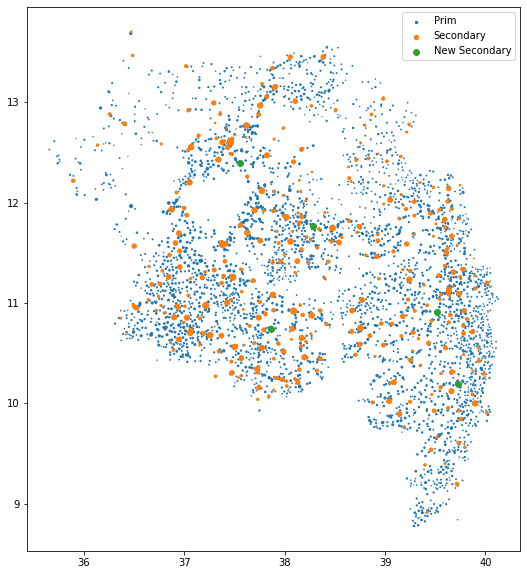

In [105]:
# it is latitude then longitude.
# box = np.array([[10.713719, 36.689328], [10.713719, 36.96973],[10.964773, 36.96973], [10.964773, 36.689328], [10.713719, 36.689328]])
plt.figure(figsize=(15, 10))
# plt.plot(box[:,1], box[:,0], '.r-')
plt.scatter(df_prim_loc[:, 1], df_prim_loc[:, 0], s=df_prim_enroll/100, label="Prim") # s gives size
plt.scatter(df_sec_loc[:, 1], df_sec_loc[:, 0], s=df_sec_enroll/100, label="Secondary") # s gives size
plt.scatter(top_4['proposed_locations'][3][:, 1], top_4['proposed_locations'][3][:, 0], s = 35, marker="o", label="New Secondary") # stars for supermarkets
plt.gca().set_aspect('equal')
plt.legend()
plt.show()

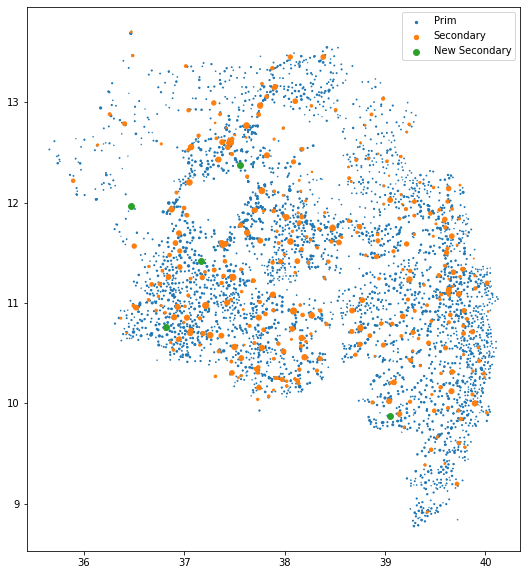

In [106]:
# it is latitude then longitude.
# box = np.array([[10.713719, 36.689328], [10.713719, 36.96973],[10.964773, 36.96973], [10.964773, 36.689328], [10.713719, 36.689328]])
plt.figure(figsize=(15, 10))
# plt.plot(box[:,1], box[:,0], '.r-')
plt.scatter(df_prim_loc[:, 1], df_prim_loc[:, 0], s=df_prim_enroll/100, label="Prim") # s gives size
plt.scatter(df_sec_loc[:, 1], df_sec_loc[:, 0], s=df_sec_enroll/100, label="Secondary") # s gives size
plt.scatter(benchmark_loc[:, 1], benchmark_loc[:, 0], s = 35, marker="o", label="New Secondary") # stars for supermarkets
plt.gca().set_aspect('equal')
plt.legend()
plt.show()

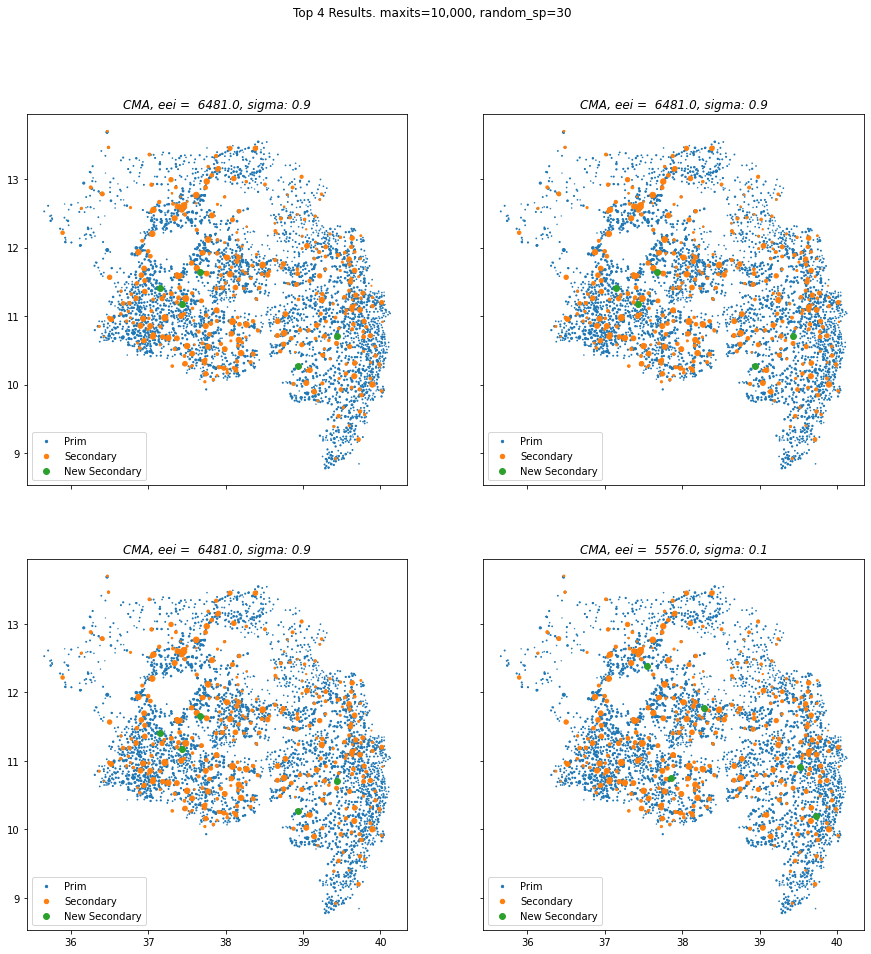

In [107]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Top 4 Results. maxits=10,000, random_sp=30')

for i in range(4):
    ax = 'ax'+str(i)
    eval(ax).scatter(df_prim_loc[:, 1], df_prim_loc[:, 0], s=df_prim_enroll/100, label="Prim") # s gives size
    if(len(df_sec) != 0): eval(ax).scatter(df_sec_loc[:, 1], df_sec_loc[:, 0], s=df_sec_enroll/100, label="Secondary") # s gives size
    eval(ax).scatter([row[1] for row in top_4['proposed_locations'][i]], 
                     [row[0] for row in top_4['proposed_locations'][i]], s = 35, \
                      marker="o", label="New Secondary") # stars for supermarkets
#     eval(ax).scatter(top_4['proposed_locations'][i][:,1], top_4['proposed_locations'][i][:,0], s = 35, \
#                      marker="o", label="New Secondary") # stars for supermarkets
    eval(ax).set_title((str(top_4.loc[i]['algorithm']) + ', eei =  ' + str(top_4.loc[i]['eei'])\
                       + ', sigma: ' + str(top_4.loc[i]['sigma'])), fontstyle='italic')

for ax in fig.get_axes():
    ax.legend()
    ax.label_outer()

CMA doesn't beat the benchmark. Need to potentially re-run with new parameters

In [108]:
winner = top_4.head(1)
winner

,level_0,index,random_starting_point,algorithm,ee,eei,proposed_locations,time,sigma
0,41,NaN,26,CMA,441105.0,6481.0,"[[11.412586866503062, 37.14785160703551], [10....",1021.792729,0.9


In [92]:
f(winner['proposed_locations'][0].flatten())

      0       1         2           3
0   4.0  1922.0  1.214625  735.000000
1   4.0  1925.0  2.000000  302.000000
2   4.0  1929.0  1.309331  340.000000
3   4.0  2322.0  4.401207   52.294589
4   3.0  2331.0  2.000000  558.000000
5   1.0  2643.0  2.000000  421.000000
6   1.0  2644.0  3.852352   53.174365
7   1.0  2645.0  0.556804   69.000000
8   1.0  2647.0  2.000000  152.000000
9   1.0  2648.0  4.444395   12.408501
10  1.0  2650.0  2.611341   82.806860
11  1.0  2651.0  1.953977  165.000000
12  2.0  3168.0  2.208488  120.035030
13  2.0  3171.0  3.003231  108.491109
14  2.0  3175.0  1.128939   49.000000
15  2.0  3181.0  0.714799  260.000000
16  2.0  3183.0  1.036627  150.000000
17  2.0  3187.0  0.871417  350.000000
18  2.0  3190.0  3.102840  118.256290
19  2.0  3199.0  1.019918   47.000000
20  2.0  3200.0  2.000000  341.000000
21  2.0  3201.0  1.332575  242.000000
22  2.0  3202.0  1.773437  141.000000
23  2.0  3203.0  2.251254  185.082249
24  2.0  3204.0  1.072481  128.000000
25  3.0  338

-440114.1880710966

In [ ]:
# %%time
# # def update_expected_enrollment(x):
# ee_old_constant = np.sum(df_sec_enroll)
# ee_old = ee_old_constant.copy()

# feeder = {} # empty dictionary for list of ps, closest ss and distance in km.
# eei = 0 # expected enrollment increase
# d = haversine_vector(df_prim_loc, winner['proposed_locations'][0], Unit.KILOMETERS, comb=True) # distance of PS to x. 
# closest = [get_close_schools(d[i], current_ps_distance) for i in range(proposed_schools)] # keep only those < 5 and < current_dist

# for ss in range(proposed_schools):
#     for ps in range(len(closest[ss])): # for each PS distance to every proposed secondary school.
#         closest_prim = closest[ss][ps] # [0] == school index, [1] == distance to nearest new secondary.
#         # if not in feeder, add to feeder dict or # if another SS is closer, replace in feeder 
#         if (closest_prim[0] not in feeder) or (closest_prim[1] < feeder[closest_prim[0]][1]): 
#             feeder[closest_prim[0]] = [ss, closest_prim[1], shape(closest_prim[1], df_prim_enroll[closest_prim[0]])]

#         # Current estimated enrollment feeding into current SS
#         distance_current = shape(current_ps_distance[closest_prim[0]], df_prim_enroll[closest_prim[0]])
#         df_prim.loc[closest_prim[0], 'expected_enroll'] = shape(closest_prim[1], df_prim_enroll[closest_prim[0]])
#         df_prim.loc[closest_prim[0], 'expected_enroll'] -= distance_current
#         df_prim.loc[closest_prim[0], 'nearest_sch_code'] = ss
#         df_prim.loc[closest_prim[0], 'nearest_lwr_sec'] = closest_prim[1]
#         ee_old -= distance_current # remove old secondary students within catchment.

# # return sum of all the feeder shaped enrollment.
# eei = sum([row[2] for row in list(feeder.values())])
# print(eei, ee_old, ee_old_constant, ee_old+eei)

In [ ]:
# f(winner['proposed_locations'][0])

In [ ]:
# f(winner['proposed_locations'][0])
# np.mean(df_sec_enroll)
# update_expected_enrollment(winner['proposed_locations'][0])
# np.sum(eei)

In [ ]:
# df_prim.groupby(['nearest_sch_code'])['expected_enroll'].agg('sum')[:5]